# Tutorial 2: information theory applied to simnulated EEG

### Dataset (Go to the tutorial of Carlos for details!!): 
__Simulated EEG__ : Modified version of the Jansen & Rit model with inhibitory synaptic plasticity.
Two subpopulations of neural masses were used to simulate the neural activity of 
individual brain regions. Using AAL atlas with 82 cortical regions.

The model uses an empirical structural connectivity matrix to connect brain regions and the white matter volume of each brain region to include a local heterogeneity.

##### The model has 3 free parameters (previously obtained):
- Global coupling (G)
- Bias (b)
- Scale (s)

### Two models fit to empirical functional connectivity data: 
- Fit to healthy controls (**HC**)
- Fit to Alzheimer's disease (**AD**)

### Optimal parameters for each condition:
- **HC**: G=0.24, b=2.6, s=-0.025
- **AD**: G=0.2, b=2.45, s=-0.075

### Objectives:
In this case, due to the size of the network we cannot use the exhaustive approach, so we will only use optimization procedures to
compute high-oder measures (**TC, DTC, O-info, S-info**):

- Greedy search algorithm
- Simulated annealing


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import JansenRitModelMulti as JR
from scipy import signal, stats


from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy
from thoi.heuristics.simulated_annealing import random_sampler
from functools import partial
from thoi.collectors import batch_to_csv



C:\Users\rherz\.conda\envs\thoi\Lib\site-packages\thoi\measures\gaussian_copula.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Simulation parameters
modelfolder = '.\\comp_neuro_workshop-main\\Notebooks Whole_Brain\\'
JR.tmax = 30 #max sim time
JR.teq = 10 #eq time for reaching steady-state dynamics
JR.dt = 0.001 #integration step
JR.downsamp = 2 #downsampling for reducing memory consumption

#networks parameters
JR.M = np.load(modelfolder+'SC_HCs.npy') #SC matrix
JR.nnodes = len(JR.M) #number of nodes
JR.norm = 1 #normalization factor

#Noise an inputs
JR.sigma = 2.5 #noise scaling factor
JR.p = 220 * np.ones(JR.nnodes) #inputs for individual nodes

#Plasticity
JR.plasticity_on = 1 #1: activated, 0: disabled
JR.target = 2.5 * np.ones(JR.nnodes) #target firing rate in Hz
JR.tau_p = 2 #time constant for plasticity (in seconds)

#Proportion of alpha neurons
JR.alpha = 0.5 * np.ones(JR.nnodes)
JR.gamma = 1 - JR.alpha

#updating some parameters
JR.update() #avoid this in extensive simulations (call it increases memory consumption).
            #just use it one time before parallelization

#Healthy controls (HCs)
SC_HCs = np.load(modelfolder+'SC_HCs.npy') #Structural connectivity 
WM_HCs = np.load(modelfolder+'WM_HCs.npy') #White matter volumes

#Patients with Alzheimer's disease (AD)
SC_AD = np.load(modelfolder+'SC_AD.npy') #Structural connectivity
WM_AD = np.load(modelfolder+'WM_AD.npy') #White matter volumes


In [3]:
# Simulating data
conds = ['HC','AD']
K = [0.24, 0.2]
bias = [2.6, 2.45]
scale = [-0.25, 0.075]
wm = [WM_HCs,WM_AD]
sc = [SC_HCs,SC_AD]

sim_eeg = list()

for k,b,s,w,c in zip(K,bias,scale,wm,sc):

    JR.K = k #global coupling
    JR.M = c.copy() #structural connectivity matrix
    JR.seed = 1 #random seed
    
    #E/I balance
    JR.target = (b + s * w) * np.ones(JR.nnodes) 
    
    #Simulation starts here
    y, t = JR.Sim(verbose = False)
    #Simulations end here
    
    #EEG-like signals
    EEG = (JR.alpha * y[:,1,:] + JR.gamma * y[:,7,:]) - (JR.alpha * y[:,2,:] + JR.gamma * y[:,8,:])
    
    #filtering and computing FC
    fmin, fmax = 8, 13
    a0,b0 = signal.bessel(3, 2 * JR.dt * JR.downsamp * np.array([fmin, fmax]), btype = 'bandpass')
    
    Vfilt = signal.filtfilt(a0, b0, EEG, 0) #filtered signals
    sim_eeg.append(Vfilt)


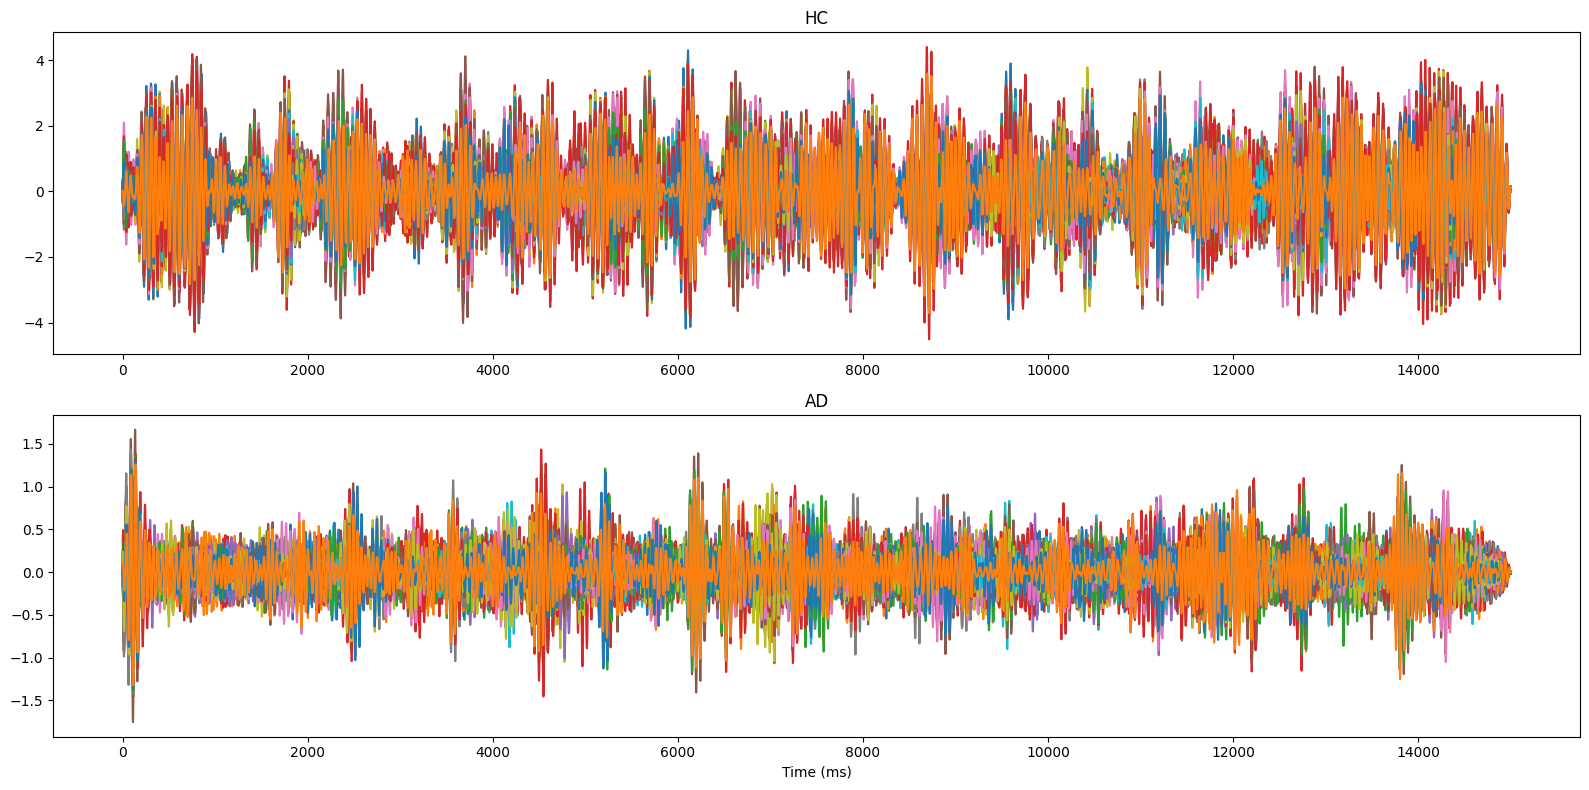

In [4]:
# Plotting signals
plt.figure(figsize=(16,8))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.plot(sim_eeg[i])
    plt.title(conds[i])

plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()


## 1. Exhaustive up to order 4 and from N-2 until N-1
---
Since the combinatorial explosion prohibits the exaustive computation for all, we will compute only up to order 4 and from N-4 until N-1. We will compute the two extremes of the orders of interactions, as those have the samllest number of interactions.

We will compute the max and the min for each measure at each order of interaction and save on the disk all the interactions to avoid memory issues.

In [6]:
# Auxiliary function for saving in disk and extracting max and min
outputfolder = "C:\\Users\\rherz\\OneDrive\\Documents\\Projects\\Frankfurt2024\\Tutorials\\hois_output\\"

batch_to_disk = partial(
    batch_to_csv,
    only_synergestic=False,
    N=82,
    output_path=outputfolder+'measures_k-{order}_batch-{bn}.tsv'
)

def batch_to_max_min(*args, output):
    df = batch_to_csv(*args, N=82)

    columns = ['tc', 'dtc', 'o', 's']
    # if max of df in col 'o' is bigger than max_value, update max_value and max_tuple
    # Find max value and corresponding row for each column
    for col in columns:
        # Max
        if df[col].max() > max_value[col]:
            max_value[col] = df[col].max()
            max_row[col] = df.loc[df[col].idxmax()]
        # Min
        if df[col].min() < min_value[col]:
            min_value[col] = df[col].min()
            min_row[col] = df.loc[df[col].idxmin()]
        
    batch_to_csv(*args, N=82, output_path=output)
    output


max_tuple = None

def concat_batches(dfs):
    var_cols = [f'var_{i}' for i in range(82)]
    df = pd.concat(dfs)
    df['order'] = df[var_cols].sum(axis=1)
    return [g for l,g in df.groupby('order')]



In [7]:
columns = ['tc', 'dtc', 'o', 's']
order2compute = [3,4] #[3,4,79,80,81] took 10min, [3,4,80,81]  took 2min 40
e_max_int_k = list()
e_min_int_k = list()
e_max_vals_k = list()
e_min_vals_k = list()

for c in range(2):
    X = sim_eeg[c]
    aux_max_int_k= list()
    aux_min_int_k= list()
    aux_max_vals_k= list()
    aux_min_vals_k= list()
    for k in order2compute:
        # empty variables to store max and min per order
        max_row = {'o': None,'s': None,'dtc': None,'tc': None}
        max_value = {'o': 0,'s': 0,'dtc': 0,'tc': 0}
        min_row = {'o': None,'s': None,'dtc': None,'tc': None}
        min_value = {'o': np.inf,'s': np.inf,'dtc': np.inf,'tc': np.inf}
        # Creating output
        save_func = partial(
        batch_to_max_min,
        output=outputfolder+conds[c]+'_k-{order}_batch-{bn}.tsv'
        )
        # Running exaustive computation for order k        
        multi_order_measures(X, min_order=k, max_order=k, 
                             batch_size=100000, 
                             batch_data_collector=save_func, 
                             batch_aggregation=lambda x: x)
        aux_max_int_k.append([np.where(max_row[col][4:])[0] for col in columns])
        aux_min_int_k.append([np.where(min_row[col][4:])[0] for col in columns])
        aux_max_vals_k.append(max_value)
        aux_min_vals_k.append(min_value)
        
    e_max_int_k.append(aux_max_int_k)
    e_min_int_k.append(aux_min_int_k)
    e_max_vals_k.append(aux_max_vals_k)
    e_min_vals_k.append(aux_min_vals_k)
    
    

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/18 [00:00<?, ?it/s]

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Batch:   0%|          | 0/18 [00:00<?, ?it/s]

In [228]:
# [e_max_int_k[0], e_max_vals_k[0], e_min_int_k[0], e_min_vals_k[0]]

## 2. Greedy search
---


In [9]:
# Running Greedy. 3min 30s for nrepeat 10 and min_k=3 and max_k=30
# took 10 min in all orders using 2 repeats
meas_name =['tc','dtc','o','s']
nmeas = 4
max_k = 20
min_k = 3
norders = max_k - min_k +1
repeat = 10 # platy with this number to improve solution
g_max_scores = list()
g_min_scores = list()
g_best_max_part_k = list()
g_best_min_part_k = list()
g_max_vals_k = list()
g_min_vals_k = list()

for c in range(2):
    X = sim_eeg[c]
    # Maximizing    
    greedy_out = [greedy(X, max_k , min_k, repeat=repeat, metric=meas, largest=True) for meas in meas_name]
    max_partitions = [x[0] for x in greedy_out]
    max_scores = [np.vstack(x[1]) for x in greedy_out]
    max_vals_k = [np.max(x,axis=0) for x in max_scores]
    max_id = [np.argmax(x,axis=0) for x in max_scores]
    best_max_part_k = [x[y]for x,y in zip(max_partitions,max_id)]
    best_max_part_k = [[np.sort(x[k,:(min_k+k)]) for k in range(0, norders)] for x in best_max_part_k]
    # Storing
    g_max_scores.append(max_scores)
    g_best_max_part_k.append(best_max_part_k)
    g_max_vals_k.append(max_vals_k)
    
    # Minimizing
    greedy_out = [greedy(X, max_k , min_k, repeat=repeat, metric=meas, largest=False) for meas in meas_name]
    min_partitions = [x[0] for x in greedy_out]
    min_scores = [np.vstack(x[1]) for x in greedy_out]
    min_vals_k = [np.max(x,axis=0) for x in min_scores]
    min_id = [np.argmax(x,axis=0) for x in min_scores]
    best_min_part_k = [x[y]for x,y in zip(min_partitions,min_id)]
    best_min_part_k = [[np.sort(x[k,:(min_k+k)]) for k in range(0, norders)] for x in best_min_part_k]
    # Storing
    g_min_scores.append(min_scores)
    g_best_min_part_k.append(best_min_part_k)
    g_min_vals_k.append(min_vals_k)

Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  97%|██████████████████████████████████████████████████████████████████▊  | 60/62 [00:00<00:00, 188.19it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  73%|██████████████████████████████████████████████████                   | 45/62 [00:00<00:00, 205.83it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates: 100%|█████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 184.52it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  69%|███████████████████████████████████████████████▊                     | 43/62 [00:00<00:00, 200.08it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  74%|███████████████████████████████████████████████████▏                 | 46/62 [00:00<00:00, 206.79it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  74%|███████████████████████████████████████████████████▏                 | 46/62 [00:00<00:00, 215.41it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  76%|████████████████████████████████████████████████████▎                | 47/62 [00:00<00:00, 151.06it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  89%|█████████████████████████████████████████████████████████████▏       | 55/62 [00:00<00:00, 177.86it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  85%|██████████████████████████████████████████████████████████▉          | 53/62 [00:00<00:00, 163.98it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  97%|██████████████████████████████████████████████████████████████████▊  | 60/62 [00:00<00:00, 181.48it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  87%|████████████████████████████████████████████████████████████         | 54/62 [00:00<00:00, 152.15it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  89%|█████████████████████████████████████████████████████████████▏       | 55/62 [00:00<00:00, 165.18it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  82%|████████████████████████████████████████████████████████▊            | 51/62 [00:00<00:00, 163.57it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates: 100%|██████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 81.95it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  89%|██████████████████████████████████████████████████████████████        | 55/62 [00:00<00:00, 75.65it/s]


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Candidates:  82%|████████████████████████████████████████████████████████▊            | 51/62 [00:00<00:00, 141.81it/s]


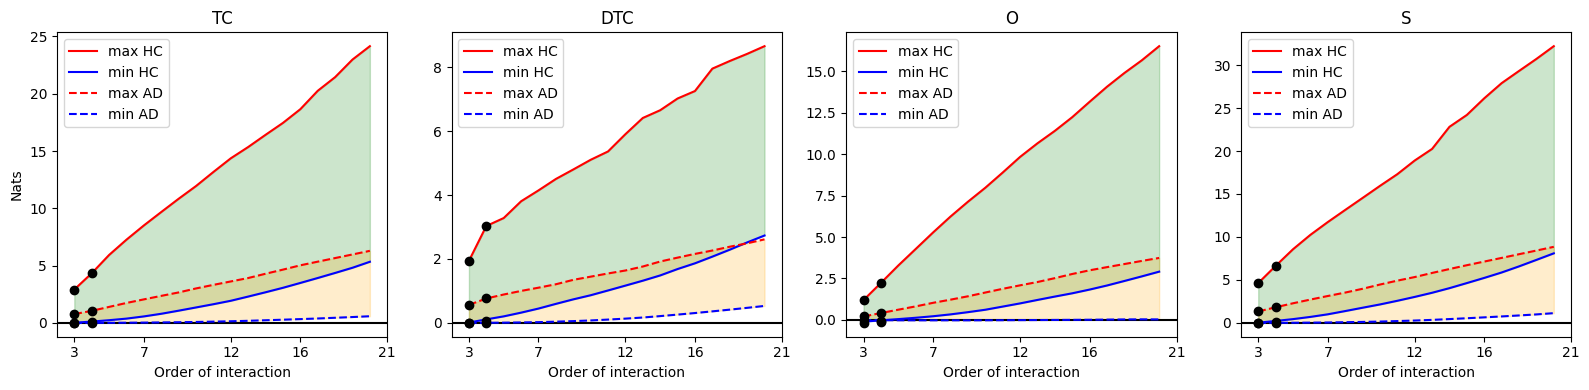

In [10]:
# Plotting
xx = np.arange(3,max_k+1)
plt.figure(figsize=(16,4))
cols = ['g','orange']
linstyle = ['-','--']
for m_id, meas in enumerate(meas_name):
    # Plotting measure per orde
    plt.subplot(1,4,m_id+1)
    plt.axhline(y=0,color='k')    
        
    for c in range(2):
        plt.plot(xx,g_max_vals_k[c][m_id], 'r', label='max '+conds[c], linestyle=linstyle[c])
        plt.plot(xx,g_min_vals_k[c][m_id],'b', label='min '+conds[c], linestyle=linstyle[c])
        plt.fill_between(xx, g_min_vals_k[c][m_id], g_max_vals_k[c][m_id], color=cols[c], alpha=0.2)
            # Plotting true value
        for kid,k in enumerate(order2compute):
            plt.plot(k,e_max_vals_k[c][kid][meas],'ko')
            plt.plot(k,e_min_vals_k[c][kid][meas],'ko')   

    plt.xlim([2,max_k+1])
    # plt.ylim([-1.1,1.1])
    plt.title(meas.upper())
    plt.legend()
    plt.xticks(np.floor(np.linspace(3,max_k+1,5)))
    plt.xlabel('Order of interaction')
    if m_id==0:
        plt.ylabel('Nats')
        
    # 
plt.tight_layout()
plt.show()

## 3. Simulated annealing
---


In [11]:
# Running simulated annealing
# ~1hr in intel5 from 3 to 20, 10 repeats
max_k = 20
min_k = 3
norders = max_k - min_k +1
repeat = 2 # 

sa_best_max_part_k = list()
sa_best_min_part_k = list()
sa_max_vals_k = list()
sa_min_vals_k = list()

for c in range(2):
    max_vals_k = np.zeros((nmeas,norders))
    min_vals_k = np.zeros((nmeas,norders))
    best_max_part_k = list()
    best_min_part_k = list()
    
    X = sim_eeg[c]
       
    
    for k in range(min_k,max_k+1):
        print('Order:',k)
        # Maximizing
        print('Maximizing')
        sa_out = [simulated_annealing(X, order=k, repeat=repeat, metric=meas, largest=True) for meas in meas_name]
        max_partitions = [x[0] for x in sa_out]
        max_scores = [np.vstack(x[1]) for x in sa_out]
        max_vals_k[:,k-min_k] = np.squeeze(np.max(max_scores,axis=1))
        max_vals_k_id = np.squeeze(np.argmax(max_scores,axis=1))
        best_max_part_k.append([x[y] for x,y in zip(max_partitions,max_vals_k_id)])
                
        # Minimizing
        print('Minimizing')
        sa_out = [simulated_annealing(X, order=k, repeat=repeat, metric=meas, largest=False) for meas in meas_name]
        min_partitions = [x[0] for x in sa_out]
        min_scores = [np.hstack(x[1]) for x in sa_out]
        min_vals_k[:,k-min_k] = np.squeeze(np.min(min_scores,axis=1))
        min_vals_k_id = np.squeeze(np.argmax(min_scores,axis=1))
        best_min_part_k.append([x[y] for x,y in zip(min_partitions,min_vals_k_id)])
    # storting
    sa_best_max_part_k.append(best_max_part_k)
    sa_max_vals_k.append(max_vals_k)
    sa_best_min_part_k.append(best_min_part_k)
    sa_min_vals_k.append(min_vals_k)

Order: 3
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 4
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 5
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 6
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 7
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 8
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 9
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 10
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 11
Maximizing


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 12
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 13
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 14
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 15
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 16
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 17
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 18
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 19
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 20
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 3
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 4
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 5
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 6
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 17
Maximizing


Early stop reached


Early stop reached


IOPub message rate exceeded.                                                                                           
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Early stop reached
Minimizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached
Order: 18
Maximizing


Early stop reached


Early stop reached


Early stop reached


Early stop reached


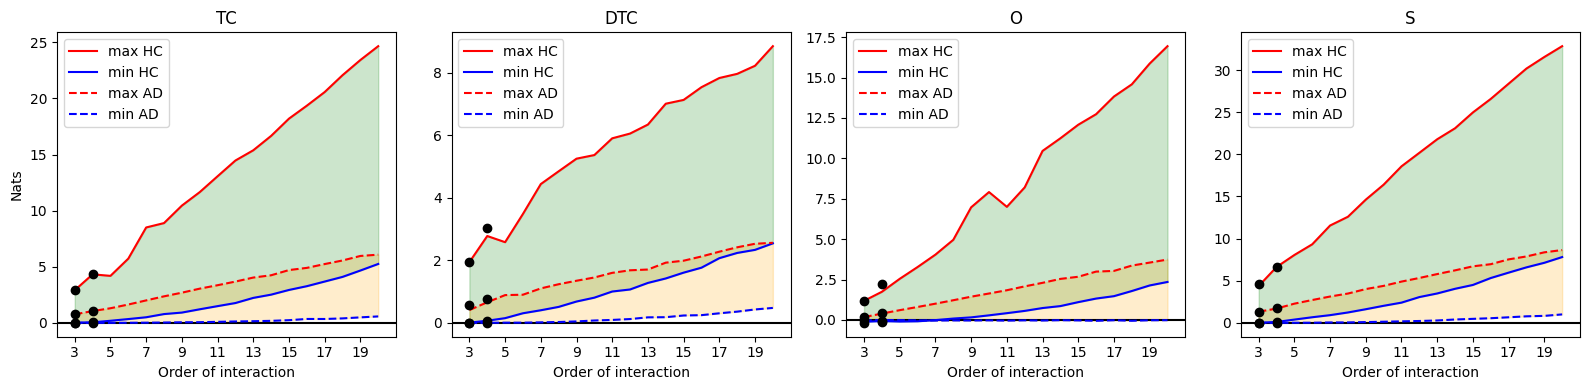

In [12]:
# Plotting
xx = np.arange(min_k,max_k+1)
plt.figure(figsize=(16,4))
cols = ['g','orange']
linstyle = ['-','--']
for m_id, meas in enumerate(meas_name):
    # Plotting measure per orde
    plt.subplot(1,4,m_id+1)
    plt.axhline(y=0,color='k')    
    for c in range(2):
        plt.plot(xx,sa_max_vals_k[c][m_id], 'r', label='max '+conds[c], linestyle=linstyle[c])
        plt.plot(xx,sa_min_vals_k[c][m_id],'b', label='min '+conds[c], linestyle=linstyle[c])
        plt.fill_between(xx, sa_min_vals_k[c][m_id], sa_max_vals_k[c][m_id], color=cols[c], alpha=0.2)
        for kid,k in enumerate(order2compute):
            plt.plot(k,e_max_vals_k[c][kid][meas],'ko')
            plt.plot(k,e_min_vals_k[c][kid][meas],'ko') 

    plt.xlim([2,max_k+1])
    # plt.ylim([-1.1,1.1])
    plt.title(meas.upper())
    plt.legend()
    plt.xticks(np.arange(3,max_k+1,2))
    plt.xlabel('Order of interaction')
    if m_id==0:
        plt.ylabel('Nats')
        
    # 
plt.tight_layout()
plt.show()